In [430]:
%%javascript
<!-- Ignore this block -->
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [431]:
#%config InlineBackend.figure_format = 'retina'

from __future__ import division
import pandas as pd
from itertools import product
import numpy as np
from math import sqrt, isnan
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## generatePearsonCoefficient Procedure
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec">
For sample:-
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0">
For selecting some features and for dropping others I am using Pearson's Coefficient. The value of Pearson's coefficient lies between [-1, 1] and tells how two features are related<br>
<table>
<tr><td>Strength of Association</td><td>Positive</td><td>Negative</td></tr><tr><td>Small</td><td>.1 to .3  </td><td>-0.1 to -0.3  </td></tr><tr><td>Medium</td><td>.3 to .5  </td><td>-0.3 to -0.5  </td></tr><tr><td>Large</td><td>.5 to 1.0 </td><td>-0.5 to -1.0  </td></tr></table>


In [432]:
"""Generate pearson's coefficient"""

def generatePearsonCoefficient(A, B):
    A = A - A.mean()
    B = B - B.mean()
    return ((A * B).sum())/(sqrt((A * A).sum()) * sqrt((B * B).sum())) 

## Feature scaling
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b0aa2e7d203db1526c577192f2d9102b718eafd5">

In [433]:
def scaleFeature(x):
    mean = np.mean(x)
    stdDeviation = np.std(x)
    return x.apply(lambda y: ((y * 1.0) - mean)/(stdDeviation))

## SplitDataSet Procedure
This method splits the dataset into trainset and testset based upon the trainSetSize value. For splitting the dataset, I am using pandas.sample to split the data. This gives me trainset. For testset I am calculating complement of the trainset. This I am doing by droping the index present in training set.

In [434]:
"""Splits the provided pandas dataframe into training and test dataset"""
def splitDataSet(inputDataframe, trainSetSize):
    
        trainSet = inputDataframe.sample(frac = trainSetSize)
        testSet = inputDataframe.drop(trainSet.index)
        return trainSet, testSet

## RMSE procedure
Will calculate root mean squared error for given Ytrue values and YPrediction.
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/fc187c3557d633423444d4c80a4a50cd6ecc3dd4">


In [435]:
"""Model accuracy estimator RMSE"""

def RMSE(yTrue, yPrediction):
    n = yTrue.shape[0]
    return sqrt((1.0) * np.sum(np.square((yTrue - yPrediction))))/n

## Regularization
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d55221bf8c9b730ff7c4eddddb9473af47bb1d1c">

### L2 loss
L2 loss or Tikhonov regularization
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/7328255ad4abce052b3f6f39c43e974808d0cdb6">
Caution: Do not regularize B0 or bias term

In [436]:
def l2Loss(regularizationParameter, weight):
    loss = 2 * regularizationParameter * weight
    "Remove impact on bias"
    loss[0] = 0
    return loss

## miniBatchGradientDescent

In [437]:
"""If no step length controller is provided then values of alpha will be taken as step length.
Else the step length controller will be used. Additional parameters to the controller are
provided by stepLengthControllerParameters"""

def miniBatchGradientDescent(xTrain, yTrain, xTest, yTest, beta, epochs = 5, 
                             batchSize = 50, verbose = 0, alpha = 1.1e-5, 
                             regularizationParameter = 9e-2, regularization = None):
    
    xTrain = np.insert(xTrain, 0, 1, axis = 1)
    xTest = np.insert(xTest, 0, 1, axis = 1)
    
    xTrain = xTrain * 1.0
    yTrain = yTrain * 1.0

    xTest = xTest * 1.0
    yTest = yTest * 1.0

    
    """For plotting graphs"""
    trainRMSE = []
    testRMSE = []
    
   # if stepLengthController != None:
   #     print("Warning using stepLengthController alpha values will be rewritten")
    
    indices = np.array(range(0, len(xTrain)))
    for i in range(0, epochs):
        
        if verbose:
            print("Epoch-"+str(i))
        
        
        """Shuffle the indices"""                        
        np.random.shuffle(indices)
        
        """Will split. May be uneven"""
        batches = np.array_split(indices, batchSize)
        
        if verbose:
            print("Total batches created"+str(len(batches)))
        
        index = 0
        while index < len(xTrain):
            
            batch = indices[index : index + batchSize]
            index = index + batchSize
            
            """Select required x and y subsets"""
            x = np.take(xTrain, batch, axis = 0)
            y = np.take(yTrain, batch, axis = 0)
            
            prediction = np.dot(beta, x.T)
            residual = prediction - y
            gradient = np.dot(residual, x) * 2
        
            
            """Gradient descent"""
            regFactor = 0
            if regularization != None:
                regFactor = regularization(regularizationParameter, beta)
                
            beta = beta - (alpha * (gradient + regFactor))
                
        
        if verbose:
            print beta
        
        """Calculating RMSE for train and test set"""
        xTrainPrediction = np.dot(beta, xTrain.T)
        xTestPrediction = np.dot(beta, xTest.T)
        
        trainRMSE.append(RMSE(yTrain, xTrainPrediction))
        testRMSE.append(RMSE(yTest, xTestPrediction))
    return beta, trainRMSE, testRMSE

## kFoldAnalysis

In [438]:
def kFoldAnalysis(xTrain, yTrain, model, modelParameters, nFolds):
    
    indices = np.array(range(0, len(xTrain)))
    folds = np.array_split(indices, nFolds)
    
    analysisMetricList = []
    trainRMSEList = []
    testRMSEList = []
    
    for i in range(0, len(folds)):
        validationSet = folds[i]
        
        """Set difference"""
        trainSet = np.setdiff1d(indices, validationSet)
        
        modelParameters['xTrain'] = np.take(xTrain, trainSet, axis = 0)
        modelParameters['yTrain'] = np.take(yTrain, trainSet, axis = 0)
        modelParameters['xTest'] = np.take(xTrain, validationSet, axis = 0)
        modelParameters['yTest'] = np.take(yTrain, validationSet, axis = 0)
        
        modelParams, trainRMSE, testRMSE = model(**modelParameters)
        analysisMetricList.append(testRMSE[-1])
        trainRMSEList.append(trainRMSE)
        testRMSEList.append(testRMSE)
        
    return modelParams, trainRMSEList, testRMSEList, analysisMetricList
    

## GridSearch

In [439]:
def gridSearch(xTrain, yTrain, xTest, yTest, model, modelParameters, hyperParameters, 
               nFolds = 1, reTrain = True, plotGraphs = False):
    
    """For storing is the best parameters"""
    leastRMSE = None
    bestModel = None
    bestHyperParams = None
    
    """Generate the parameter grid"""
    parameterGrid = []
    gridKeys = []
    
    parameterGrid = list(product(*hyperParameters.values()))
    hyperParameterKeys = hyperParameters.keys()
    
    """For plottong graphs"""
    if plotGraphs:
        plt.close()
        plotHeight = 10
        plotWidth = 20
        index = 0
        fig, axs = plt.subplots(len(parameterGrid), 2, figsize=(plotWidth, plotHeight * len(parameterGrid)))
        
          
        fig = plt.figure()
        fig.set_figheight(15)
        fig.set_figwidth(15)
        ax = fig.add_subplot(111, projection='3d')
            
        
    """Grid search for cartesian product of hyperParameters"""    
    for parameterMesh in parameterGrid:
        hyperParameterMesh = {}
        for k,v in zip(hyperParameterKeys, parameterMesh):
            hyperParameterMesh[k] = v
        
        """Combine model Parameters"""
        updatedParam = modelParameters.copy()
        updatedParam.update(hyperParameterMesh)
        
        """Perform grid search with cross validation"""
        if nFolds > 1:
            modelParams, trainRMSEList, testRMSEList, analysisMetricList = kFoldAnalysis(model = model,
                                                                                        xTrain = xTrain,
                                                                                        yTrain = yTrain,
                                                                                        nFolds = nFolds,
                                                                                        modelParameters = updatedParam)  
            
            
            """For storing best model"""
            avg = np.average(analysisMetricList)
            if leastRMSE == None or avg < leastRMSE:
                leastRMSE = avg
                bestModel = modelParams
                bestHyperParams = hyperParameterMesh
            
            """For plotting"""
            if plotGraphs:
                foldIndex = 1
                
                ax.scatter(hyperParameterMesh['alpha'], hyperParameterMesh['regularizationParameter'], 
                           avg, marker = 'o', label = str(hyperParameterMesh))
                              
                for train, test in zip(trainRMSEList, testRMSEList):
                    axs[index][0].plot(train, label = "Fold-" + str(foldIndex))
                    axs[index][1].plot(test, label = "Fold-" + str(foldIndex))
                    foldIndex = foldIndex + 1
                
                axs[index][0].legend()
                axs[index][0].grid()
                
                axs[index][1].legend()
                axs[index][1].grid()
                
                axs[index][0].set_title("Train set for " + str(hyperParameterMesh))
                axs[index][1].set_title("Validation set for " + str(hyperParameterMesh))
                    
                
                index = index + 1
            
                
            """Perform only grid search and no cross validation. Test set will be used for validation"""    
        else:
            trainedModel, trainRMSE, testRMSE = model(xTrain, yTrain, xTest, yTest, **updatedParam)
            
            """For storing best model"""
            if leastRMSE == None or testRMSE[-1] < leastRMSE:
                leastRMSE = testRMSE[-1]
                bestModel = trainedModel
                bestHyperParams = hyperParameterMesh
            
            """For plotting graphs"""
            if plotGraphs:
                axs[index][0].plot(trainRMSE, label = "Training set RMSE for " + str(hyperParameterMesh))
                axs[index][0].legend()
                axs[index][0].grid()
                axs[index][1].plot(testRMSE, label = "Test set RMSE for " + str(hyperParameterMesh))
                axs[index][1].legend()
                axs[index][1].grid()
                index = index + 1
    
    if plotGraphs:
        ax.legend()
        ax.set_xlabel('alpha')
        ax.set_ylabel('regularizationParameter')
        ax.set_zlabel('RMSE')
        plt.show()
        plt.close()
    
    if reTrain:
        
        """Combine model Parameters"""
        updatedParam = modelParameters.copy()
        updatedParam.update(bestHyperParams)

        bestModel, trainRMSE, testRMSE = model(xTrain, yTrain, xTest, yTest, **updatedParam)
        
        if plotGraphs:
            plt.close()
            plotHeight = 10
            plotWidth = 20
            fig, axs = plt.subplots(1, 2, figsize = (plotWidth, plotHeight)) 
            
            plt.suptitle("Best model")

            axs[0].plot(trainRMSE, label = "Training set RMSE for " + str(bestHyperParams))
            axs[0].legend()
            axs[0].grid()
            axs[1].plot(testRMSE, label = "Test set RMSE for " + str(bestHyperParams))
            axs[1].legend()
            axs[1].grid()
        
            plt.show()
        
        
      
        
        
    
    return bestModel, bestHyperParams

## Get quadratic variables

In [440]:
def getQuadraticDerivedVariables(inputDataFrame, keys, degree):
    newKeys = []
    for key in keys:
        inputDataFrame[key+" Degree-" + str(degree)] = inputDataFrame[key] ** degree
        newKeys.append(key+" Degree-" + str(degree))
    return newKeys

## Make Prediction

In [441]:
def predict(modelParameters, x):
    x = np.insert(x, 0, 1, axis = 1)
    x = x * 1
    return np.dot(modelParameters, x.T)

## Wine dataset

### Load dataset

In [442]:
""" File path change accordingly"""
directoryPath = "Data"

wineData = pd.read_csv(directoryPath+"/winequality-red.csv", sep=";")
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [443]:
wineData.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [444]:
wineData.dropna(inplace = True)
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [445]:
totalFeatureSet = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                   'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
                   'sulphates', 'alcohol']

### Using quadratic model

In [446]:
derivedFeatures = getQuadraticDerivedVariables(wineData, totalFeatureSet, 2)
totalFeatureSet.extend(derivedFeatures)
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,volatile acidity Degree-2,citric acid Degree-2,residual sugar Degree-2,chlorides Degree-2,free sulfur dioxide Degree-2,total sulfur dioxide Degree-2,density Degree-2,pH Degree-2,sulphates Degree-2,alcohol Degree-2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.4900,0.0000,3.61,0.005776,121.0,1156.0,0.995605,12.3201,0.3136,88.36
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.7744,0.0000,6.76,0.009604,625.0,4489.0,0.993610,10.2400,0.4624,96.04
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.5776,0.0016,5.29,0.008464,225.0,2916.0,0.994009,10.6276,0.4225,96.04
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0784,0.3136,3.61,0.005625,289.0,3600.0,0.996004,9.9856,0.3364,96.04
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.4900,0.0000,3.61,0.005776,121.0,1156.0,0.995605,12.3201,0.3136,88.36


### Feature scaling

In [447]:
for feature in wineData:
    if feature != "quality":
        wineData[feature] = scaleFeature(wineData[feature])

wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,volatile acidity Degree-2,citric acid Degree-2,residual sugar Degree-2,chlorides Degree-2,free sulfur dioxide Degree-2,total sulfur dioxide Degree-2,density Degree-2,pH Degree-2,sulphates Degree-2,alcohol Degree-2
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,...,0.826144,-0.896588,-0.278089,-0.185037,-0.481752,-0.407861,0.557585,1.297220,-0.488547,-0.922026
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,...,2.136085,-0.896588,-0.096433,-0.011775,0.528413,0.244230,0.027313,-0.727336,0.001731,-0.591340
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,...,1.229627,-0.883705,-0.181205,-0.063373,-0.273305,-0.063523,0.133325,-0.350086,-0.129734,-0.591340
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,...,-1.069679,1.628479,-0.278089,-0.191871,-0.145030,0.070300,0.663703,-0.974943,-0.413423,-0.591340
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,...,0.826144,-0.896588,-0.278089,-0.185037,-0.481752,-0.407861,0.557585,1.297220,-0.488547,-0.922026


### Checking corelation

In [448]:
for column in wineData:
    if column != "quality":
        print("The corelation between " + column +" vs quality is " + 
              str(generatePearsonCoefficient(wineData[column], wineData['quality'])))

The corelation between fixed acidity vs quality is 0.124051649113
The corelation between volatile acidity vs quality is -0.390557780264
The corelation between citric acid vs quality is 0.226372514318
The corelation between residual sugar vs quality is 0.0137316373401
The corelation between chlorides vs quality is -0.12890655993
The corelation between free sulfur dioxide vs quality is -0.0506560572443
The corelation between total sulfur dioxide vs quality is -0.185100288927
The corelation between density vs quality is -0.174919227783
The corelation between pH vs quality is -0.0577313912054
The corelation between sulphates vs quality is 0.251397079069
The corelation between alcohol vs quality is 0.476166324001
The corelation between fixed acidity Degree-2 vs quality is 0.128116454698
The corelation between volatile acidity Degree-2 vs quality is -0.368027866982
The corelation between citric acid Degree-2 vs quality is 0.216431862443
The corelation between residual sugar Degree-2 vs quali

We will drop features with low corelation

In [449]:
totalFeatureSet.remove('residual sugar')
totalFeatureSet.remove('free sulfur dioxide')
totalFeatureSet.remove('pH')
totalFeatureSet.remove('residual sugar Degree-2')
totalFeatureSet.remove('chlorides Degree-2')
totalFeatureSet.remove('free sulfur dioxide Degree-2')
totalFeatureSet.remove('pH Degree-2')
print totalFeatureSet

['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol', 'fixed acidity Degree-2', 'volatile acidity Degree-2', 'citric acid Degree-2', 'total sulfur dioxide Degree-2', 'density Degree-2', 'sulphates Degree-2', 'alcohol Degree-2']


In [450]:
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,volatile acidity Degree-2,citric acid Degree-2,residual sugar Degree-2,chlorides Degree-2,free sulfur dioxide Degree-2,total sulfur dioxide Degree-2,density Degree-2,pH Degree-2,sulphates Degree-2,alcohol Degree-2
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,...,0.826144,-0.896588,-0.278089,-0.185037,-0.481752,-0.407861,0.557585,1.297220,-0.488547,-0.922026
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,...,2.136085,-0.896588,-0.096433,-0.011775,0.528413,0.244230,0.027313,-0.727336,0.001731,-0.591340
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,...,1.229627,-0.883705,-0.181205,-0.063373,-0.273305,-0.063523,0.133325,-0.350086,-0.129734,-0.591340
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,...,-1.069679,1.628479,-0.278089,-0.191871,-0.145030,0.070300,0.663703,-0.974943,-0.413423,-0.591340
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,...,0.826144,-0.896588,-0.278089,-0.185037,-0.481752,-0.407861,0.557585,1.297220,-0.488547,-0.922026


### Split dataset

In [451]:
trainSet, testSet = splitDataSet(wineData, 0.8)

In [452]:
xTrain = trainSet.as_matrix(columns = totalFeatureSet)
xTest = testSet.as_matrix(columns = totalFeatureSet)

yTrain = trainSet['quality']
yTest = testSet['quality']

### Regularized vs non regularized model

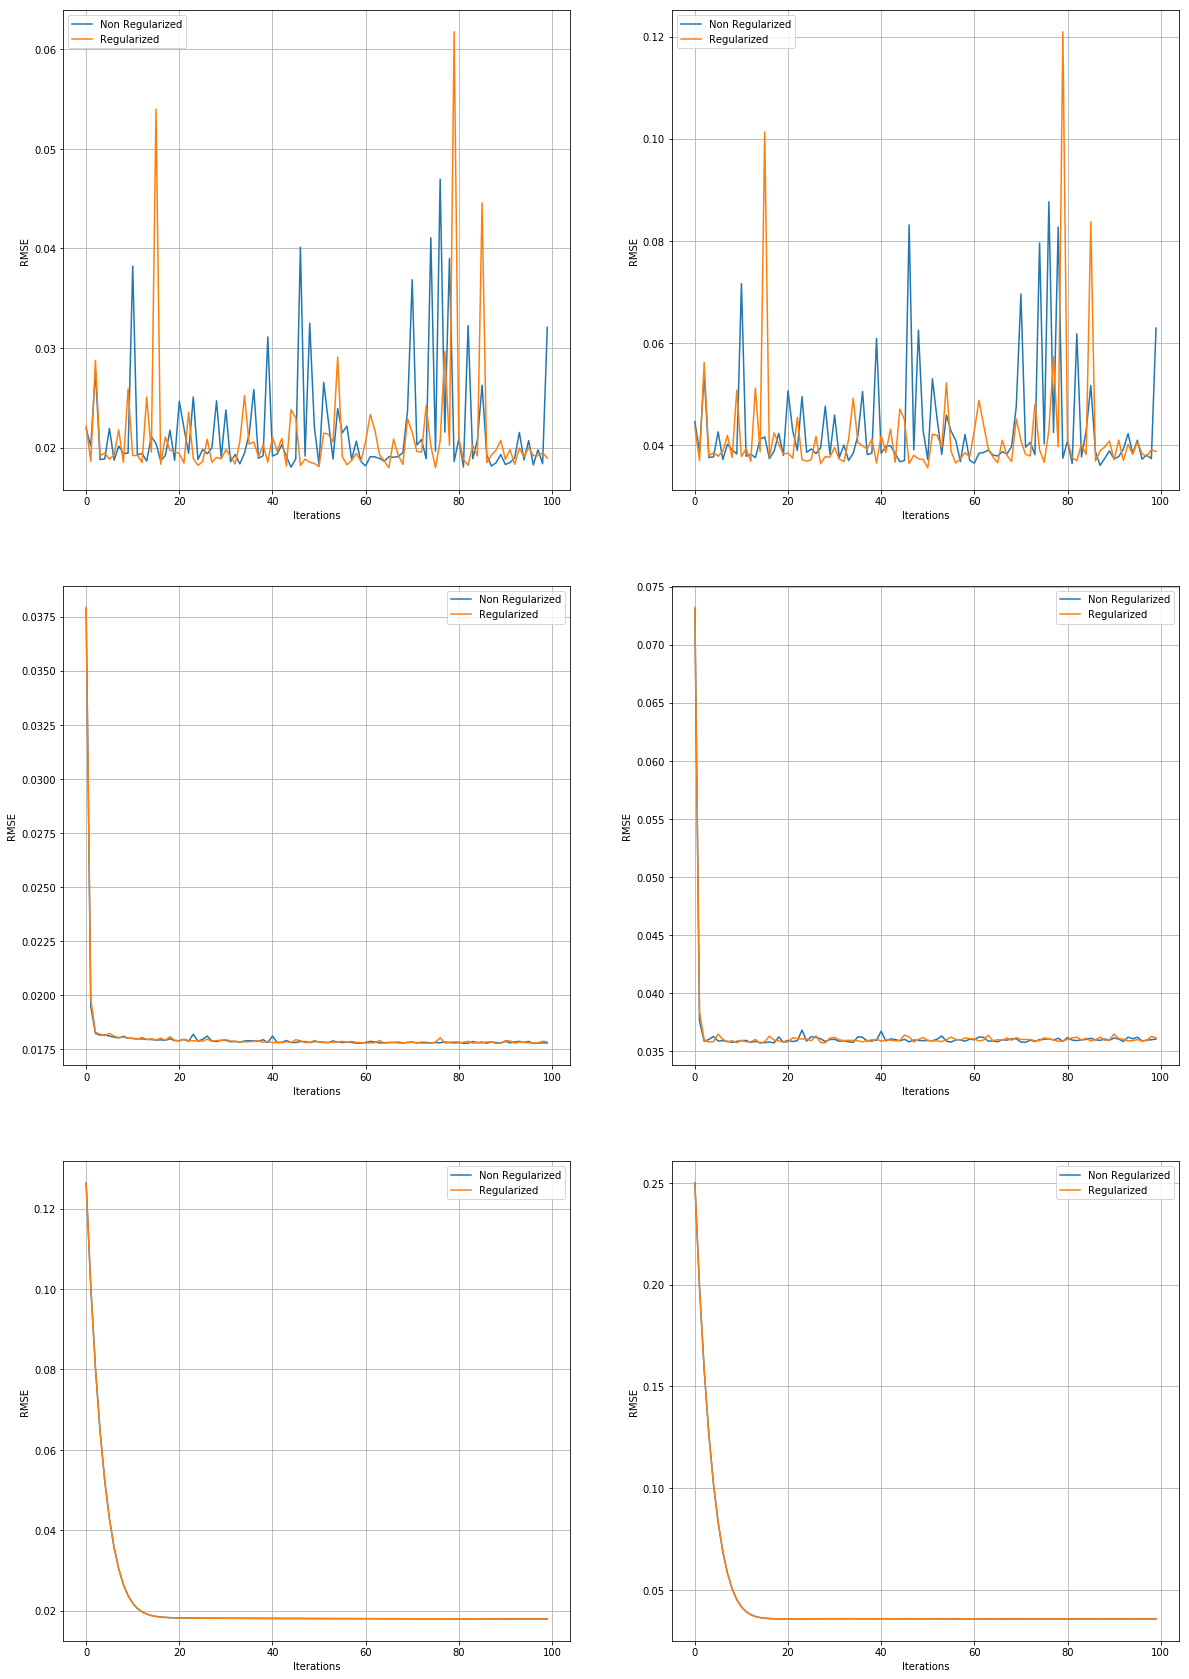

In [453]:
plt.close()


modelParameters = {"beta":np.zeros(xTrain.shape[1] + 1), "epochs":100, 
                   "batchSize":50, "verbose":0}

alphaList = [4.0e-3, 5.9e-4, 9.1e-5]
regularizationParameterList = [9.9e-9, 1.9e-7, 5.9e-3]

"""For plotting traph"""
plotHeight = 10
plotWidth = 20
index = 0
fig, axs = plt.subplots(len(alphaList), 2, figsize=(plotWidth, plotHeight * len(alphaList)))

for alpha, regularizationParameter in zip(alphaList, regularizationParameterList):
    betaNonReg, trainRMSENonReg, testRMSENonReg = miniBatchGradientDescent(xTrain, yTrain, xTest, yTest,
                                                                           alpha = alpha, **modelParameters)
    
    betaReg, trainRMSEReg, testRMSEReg = miniBatchGradientDescent(xTrain, yTrain, xTest, yTest,
                                                                           alpha = alpha, regularization = l2Loss,
                                                                      regularizationParameter = regularizationParameter,
                                                                      **modelParameters)
    axs[index][0].set_xlabel("Iterations")
    axs[index][1].set_xlabel("Iterations")

    axs[index][0].set_ylabel("RMSE")
    axs[index][1].set_ylabel("RMSE")
    
    
    axs[index][0].plot(trainRMSENonReg, label = "Non Regularized")
    axs[index][0].plot(trainRMSEReg, label = "Regularized")
    axs[index][0].grid()
    axs[index][0].legend()

    
    axs[index][1].plot(testRMSENonReg, label = "Non Regularized")
    axs[index][1].plot(testRMSEReg, label = "Regularized")
    axs[index][1].grid()
    axs[index][1].legend()
    index = index + 1

plt.show()    
    

A bad value of regularization parameter results into diverging rather than converging graph. This is evident in the third graph.
It is very difficult to calculate hyper parameters in this way.
Hence we use grid search.

### Using grid search with k-fold 
Here plotting takes some time. Make plotGraphs as false to avoid plotting of graphs

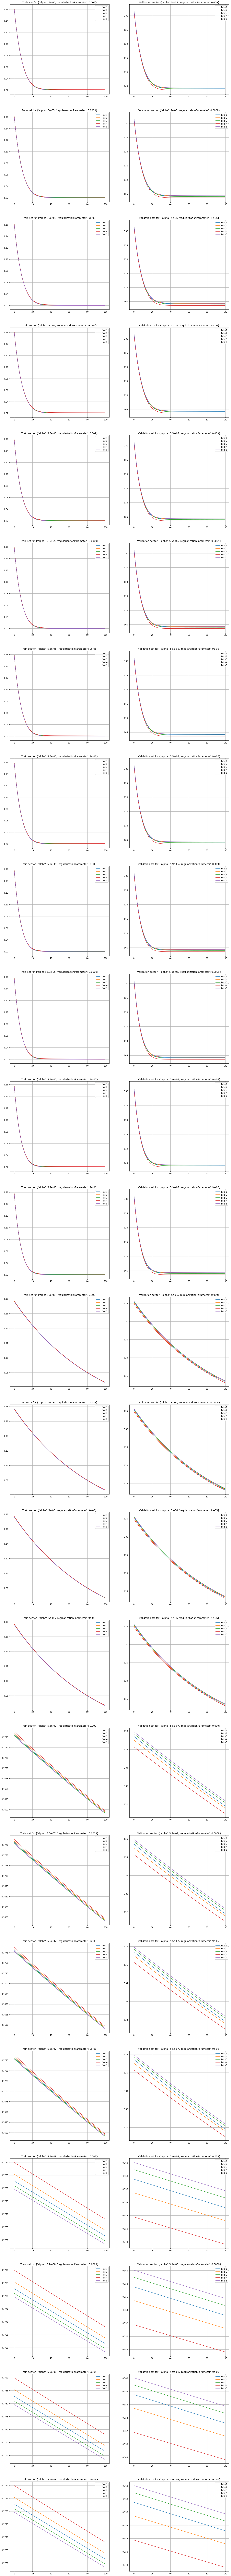

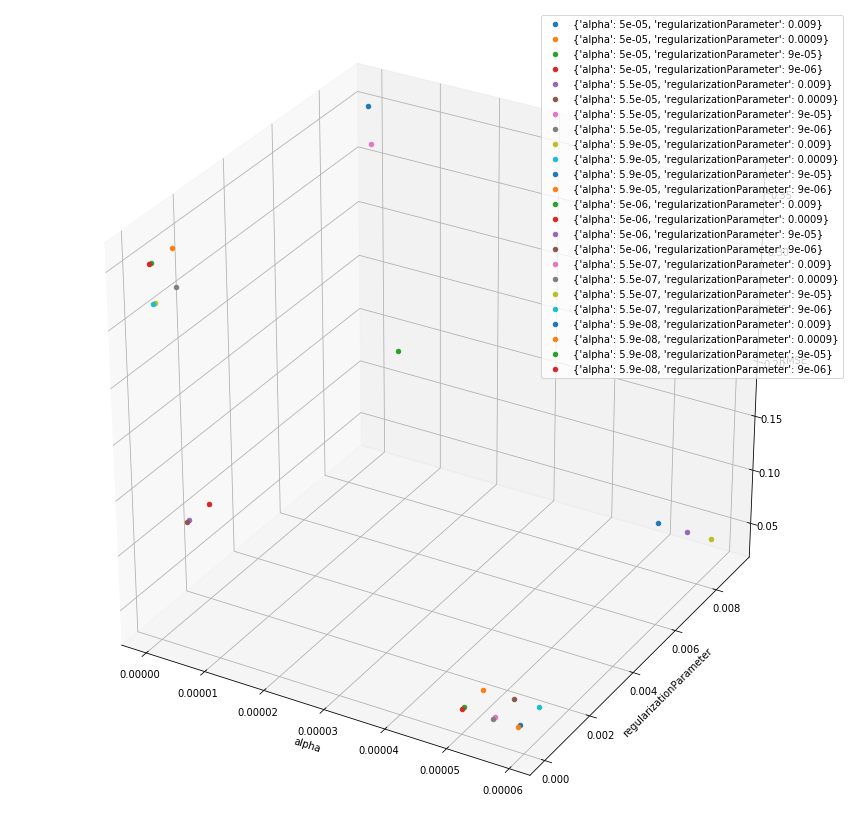

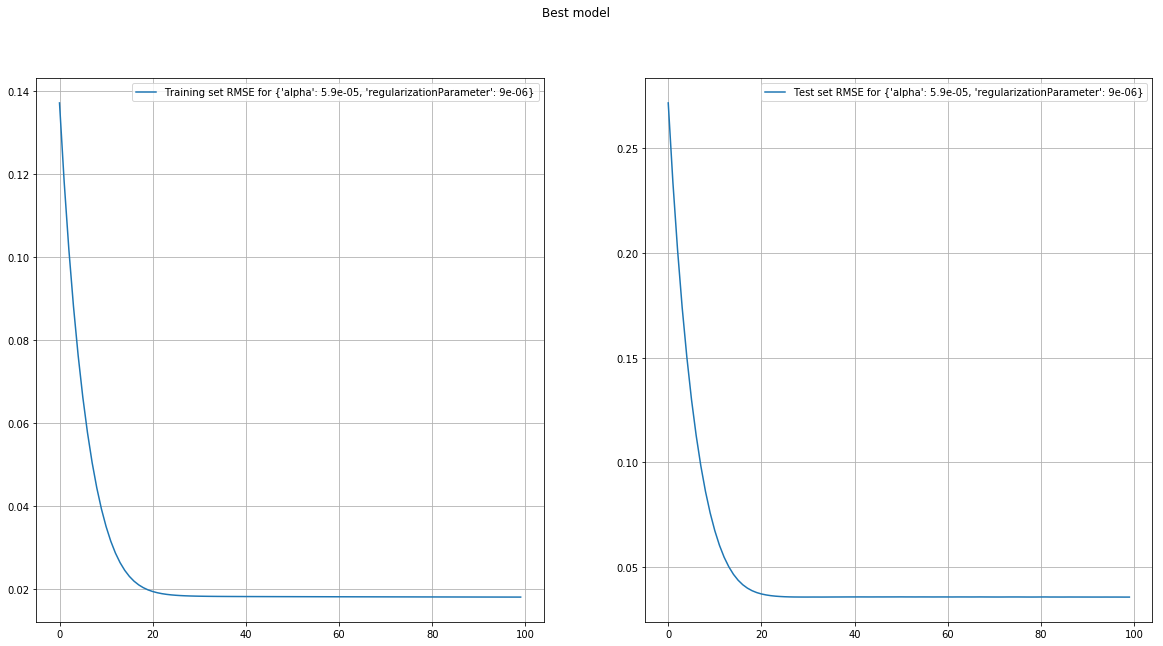

In [454]:
"""Parameter grid for searching"""

gridParameters = {
    "alpha":[5.0e-5, 5.5e-5, 5.9e-5, 5.0e-6, 5.5e-7, 5.9e-8],
    "regularizationParameter":[9e-3, 9e-4, 9e-5, 9e-6]
}


modelParameters = {
    "beta":np.zeros(xTrain.shape[1] + 1), 
    "epochs":100, 
    "batchSize":50, 
    "verbose":0,
    "regularization" : l2Loss
}

model, hyperParams = gridSearch(xTrain, yTrain, xTest, yTest, 
           miniBatchGradientDescent, modelParameters, 
           gridParameters, nFolds = 5, reTrain = True, plotGraphs = True)

Here grid search is used to calculate best model. All possible combinations of hyperparameters are calculated. Then kfold analyis is done. The one with least error is selected as best model